In [1]:
# imports.py
from imports import *
# custom mods
import tidy

import nltk
import pandas as pd
import numpy as np
from env import *

import tweepy as tw 
import scipy.stats as stats

from datetime import datetime

import nltk.sentiment
import wrangle

from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings("ignore")
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, r2_score, mean_squared_error
from datetime import datetime, timedelta
from matplotlib.dates import date2num

In [2]:
df = wrangle.wrangle_df()

cached csv


<AxesSubplot:>

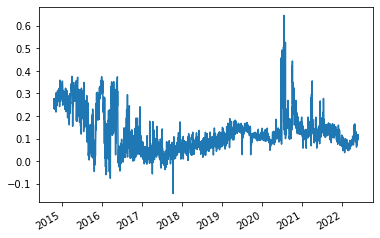

In [3]:
df.sentiment.plot()

In [4]:
# df['obv_close_product'] = obv_ind_df.obv_close_product

In [5]:
# def add_twitter_sentiment(df, filepath = './project_csvs/twitter_sentiment_btc.csv'):
#     """ Adds the Twitter Sentiment (average per day) to the prices df """
    
#     twitter_sentiment = pd.read_csv('./project_csvs/twitter_sentiment_btc.csv', index_col = 0)
    
#     twitter_sentiment.index = pd.to_datetime(twitter_sentiment.index)
    
#     twitter_sentiment.index = twitter_sentiment.index.date
    
#     df = df.copy()
    
#     df = pd.concat([df, twitter_sentiment], axis = 1)
    
#     return df

In [6]:
# add_twitter_sentiment(df)

In [7]:
df = tidy.explore_df()

cached csv


In [8]:
df=tidy.explore_df()

cached csv


# Target exploration

In [9]:
df.index.min()

Timestamp('2014-09-17 00:00:00')

In [10]:
df.index.max()

Timestamp('2022-05-24 00:00:00')

<AxesSubplot:>

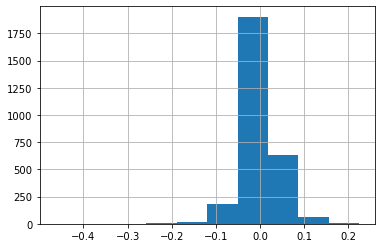

In [11]:
df.fwd_log_ret.hist()

<AxesSubplot:>

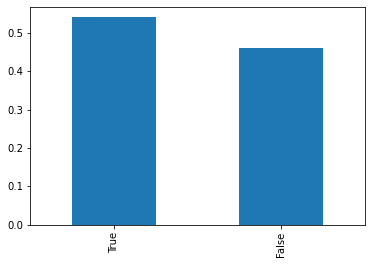

In [12]:
df.fwd_close_positive.value_counts(normalize=True).plot.bar()

# Volatility exploration

### When volatility is high what kind of returns are expected? 
- Measure this using ATR:
    - TR = Max[(H-L), Abs(H-Cp), Abs(L-Cp)]
    - ATR = (1/n)* sum(TRi)

In [13]:
from talib import ATR

In [14]:
def add_ATR_feature(df):
    """Adds columns with boolean of whether current and historical ATR 
    is greater than the ATR threshold (percentage)"""
    
    df_calc = df.copy()

    # Calculate the 14 day ATR and add it as column to df
    df_calc['ATR_14'] = ATR(df_calc.high, df_calc.low, df_calc.close, 14)
    # Calculate the rolling 14 day average of ATR and add it as column to df
    df_calc['avg_atr_14'] = df_calc.ATR_14.rolling(14).mean()
    # Calculate the percentage current 14 day ATR is above/below the rolling mean
    df_calc['atr_vs_historical'] = (df_calc.ATR_14 - df_calc.avg_atr_14)/df_calc.avg_atr_14
    
    thresholds_to_add = [0.01, 0.05, 0.1, 0.2, 0.3]
    
    for threshold in thresholds_to_add:
        df[f'atr_above_threshold_{threshold}'] = df_calc.atr_vs_historical>threshold
    
    return df

In [15]:
def perform_ATR_analysis(df, atr_threshold  = 0.05, make_plots = True, print_results = True, alpha = 0.05):
    """Performs analysis of returns based on current vs historical ATR.
    
    If the difference in current and historical ATR is greater than the ATR threshold (percentage)"""

    # Calculate the 14 day ATR and add it as column to df
    df['ATR_14'] = talib.ATR(df.high, df.low, df.close, 14)
    # Calculate the rolling 14 day average of ATR and add it as column to df
    df['avg_atr_14'] = df.ATR_14.rolling(14).mean()
    # Calculate the percentage current 14 day ATR is above/below the rolling mean
    df['atr_vs_historical'] = (df.ATR_14 - df.avg_atr_14)/df.avg_atr_14

    if make_plots:
    # Plot ATR 14 and close price
        fig, ax = plt.subplots(2,1,sharex=True)
        df.close.plot(ax = ax[0])
        ax[0].set_title('Close price of BTC')
        df.avg_atr_14.plot(ax = ax[1])
        ax[1].set_title('Rolling 14 day average of 14 day ATR')

    df['atr_above_threshold'] = df.atr_vs_historical>atr_threshold

    avg_return_above_threshold = round(df[df.atr_above_threshold].fwd_log_ret.mean(),6)

    # Perform one sample t-test -> is the average return of the high volatility days significantly greater than overall mean?
    t,p = stats.ttest_1samp(df[df.atr_above_threshold].fwd_log_ret, df.fwd_log_ret.mean())

    if print_results:
        print(f"Percentage of observations above threshold: {df.atr_above_threshold.mean():.2%}")

        print(f"Average next day return when ATR above threshold: {avg_return_above_threshold}")
    
        print(f"which is: {round(df[df.atr_above_threshold].fwd_log_ret.mean()/df.fwd_log_ret.mean(),3)} times overall average")
    
        if ((t>0)&(p/2<alpha)):
            print("Results significant!: t is >0",t>0,"p/2 < alpha",p<alpha)
        else:
            print("Fail to reject null hypothesis")
        
    return avg_return_above_threshold
    

In [16]:
def plot_final_ATR_results(df):
    
    thresholds_to_try = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    returns = {}
    for threshold in thresholds_to_try:
        avg_return = perform_ATR_analysis(df, atr_threshold=threshold, make_plots=False, print_results=False)
        returns[threshold] = avg_return


    # Format threshold percentage as % and plot bar plot of average log return
    pd.DataFrame({k*100: v for k,v in returns.items()}, index = ['avg_return']).T.plot.bar(legend=False)
    plt.title('Average Next Day Return when ATR is \nAbove 14 Day Average ATR by Threshold Percentage')
    plt.xlabel('Threshold Percentage')
    plt.ylabel('Average Return')
    plt.xticks(rotation=0)
    plt.axhline(df.fwd_log_ret.mean(), color = 'r')
    plt.annotate('Overall Mean', (5, 0.0017))


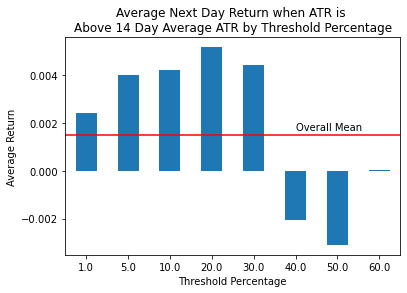

In [17]:
plot_final_ATR_results(df)

<AxesSubplot:xlabel='date'>

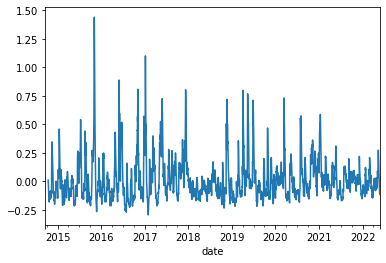

In [18]:
df.atr_vs_historical.plot()

When current ATR gets very extended from mean, what are next day returns?
- very extended defined as difference in current ATR from 14 day historical ATR as greater than the 3rd quartile

In [19]:
atr_threshold = df.atr_vs_historical.quantile(0.75)

df['atr_above_threshold'] = df.atr_vs_historical>atr_threshold

df.atr_above_threshold.mean()

0.24759529747060918

As expected, the difference in current volatility from 14 day average is above threshold 25% of the time

What is the average return when (Current ATR - Historical ATR) > threshold? How does this compare with overall average?

In [20]:
df[df.atr_above_threshold].fwd_log_ret.mean()

0.004058148250319954

How does this compare to overall average?

In [21]:
df[df.atr_above_threshold].fwd_log_ret.mean()/df.fwd_log_ret.mean()

2.7296384679490866

Nearly 3 times as high as average. Check for statistical significance at the 95% confidence level:
- H0: Days with volatility above the threshold do not exhibit above average returns
- H1: Days with volatility above the threshold return in above average next day returns

In [22]:
alpha = 0.05
t,p = stats.ttest_1samp(df[df.atr_above_threshold].fwd_log_ret, df.fwd_log_ret.mean())

print("t is >0",t>0,"p/2 < alpha",p<alpha)

t is >0 True p/2 < alpha False


Cannot reject the null hypothesis - days with above average volatility do not result in above average next day returns. Will try additional thresholds

# Bollinger Band exploration

### Bollinger bands - when price is "stretched" a certain point from its average do we expect returns to be greater?

In [23]:
from talib import BBANDS

In [24]:
# Create 5 period sma as middle band, 2 std dev +- for upper and lower bands
df['upperband2'], df['middleband'], df['lowerband2'] = BBANDS(df.close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)

df['upperband1'], df['middleband'], df['lowerband1'] = BBANDS(df.close, timeperiod=5, nbdevup=1, nbdevdn=1, matype=0)



# create columns true when low below lower band, another column true when high above upper band
df['low_below_lower1'] = df.low < df.lowerband1
df['high_above_upper1'] = df.high > df.upperband1

df['low_below_lower2'] = df.low < df.lowerband2
df['high_above_upper2'] = df.high > df.upperband2

In [25]:
df.low_below_lower1.mean()

0.46597791236195224

In [26]:
df.high_above_upper1.mean()

0.5553972212326327

What is the average forward return when low below lower and what is it when high above upper?

In [27]:
df[df.low_below_lower2].fwd_log_ret.mean()

5.468772458423057e-05

In [28]:
df[df.high_above_upper2].fwd_log_ret.mean()

0.00025614540533167523

In [29]:
df[df.low_below_lower1].fwd_log_ret.mean()

-0.0002509609606985909

In [30]:
df[df.high_above_upper1].fwd_log_ret.mean()

0.002590890403563458

In [31]:
df.fwd_log_ret.mean()

0.0014866980730122267

Overall the returns are much less than average when price is stretched 2 std dev away from the mean

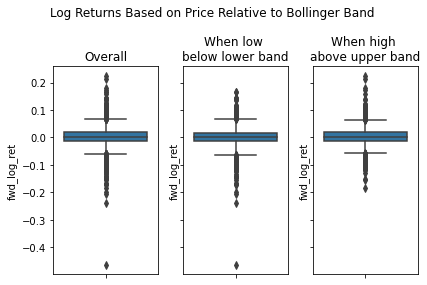

In [32]:
fig, ax = plt.subplots(1,3,sharey=True)
sns.boxplot(y=df.fwd_log_ret, ax = ax[0])
ax[0].set_title('Overall')
sns.boxplot(y=df[df.low_below_lower1].fwd_log_ret, ax=ax[1])
ax[1].set_title('When low \nbelow lower band')
sns.boxplot(y=df[df.high_above_upper1].fwd_log_ret, ax = ax[2])
ax[2].set_title('When high \nabove upper band')
plt.suptitle('Log Returns Based on Price Relative to Bollinger Band')
plt.tight_layout()

In [33]:
# plt.figure(figsize = (18,8))
# sample = df.loc['08-2020']
# sample.high.plot()
# sample.upperband.plot()
# sample.lowerband.plot()
# plt.legend()

Perform t-test

In [34]:
to_test = ['low_below_lower2', 'low_below_lower1', 'high_above_upper1', 'high_above_upper2']
overall_mean = df.fwd_log_ret.mean()
alpha = 0.05
for test in to_test:
    sample = df[df[test]].fwd_log_ret
    t,p = stats.ttest_1samp(sample, overall_mean)
    print(test, t, p/2<alpha)

low_below_lower2 -0.7212809213135888 False
low_below_lower1 -1.5194888178095236 False
high_above_upper1 1.201382924201341 False
high_above_upper2 -0.6961508741026569 False


Nothing significant

# Explore other features

### Explore consolidation then breakout of price

# Modeling

In [35]:
df = wrangle.wrangle_df()

cached csv


In [36]:
df.head(5)

,open,high,low,close,volume,fwd_log_ret,fwd_ret,fwd_pct_chg,fwd_close_positive,cross,...,atr_above_threshold_0.3,avg-fees-per-transaction,cost-per-transaction-percent,cost-per-transaction,difficulty,hash-rate,miners-revenue,transaction-fees-to-miners,sentiment,obv_close_product
2014-10-20,389.230988,390.084015,378.252014,382.845001,16419000.0,0.009437,3.630005,0.009482,1.0,0.0,...,False,0.059651,2.830044,24.826121,3.500248e+10,233157.697776,1.747486e+06,4198.799233,0.234784,0.458883
2014-10-21,382.420990,392.645996,380.834015,386.475006,14188900.0,-0.008620,-3.317016,-0.008583,0.0,0.0,...,False,0.060749,2.830044,20.194035,3.500248e+10,233157.697776,1.903490e+06,5726.216590,0.274812,0.510393
2014-10-22,386.118011,388.575989,382.248993,383.157990,11641300.0,-0.066750,-24.740998,-0.064571,0.0,0.0,...,False,0.060749,2.830044,20.194035,3.500248e+10,297537.062088,1.903490e+06,5726.216590,0.258505,0.465414
2014-10-23,382.962006,385.048004,356.446991,358.416992,26456900.0,-0.000201,-0.071991,-0.000201,0.0,0.0,...,False,0.060749,2.566983,20.194035,3.500248e+10,297537.062088,1.903490e+06,5726.216590,0.277373,0.286309
2014-10-24,358.591003,364.345001,353.304993,358.345001,15585700.0,-0.031391,-11.074005,-0.030903,0.0,0.0,...,False,0.056403,2.566983,18.762679,3.500248e+10,297537.062088,1.603290e+06,4819.681933,0.276173,0.302494


In [37]:
def rolling_split_train_and_test(df, features_to_use, features_to_scale, target, other_targets, num_splits = 5, test_size = 30):
    """ Splits dataset into train and test sets. Returns list of X_trains, X_tests, y_trains, y_tests
    
    Arguments:
    df: the full dataset included features and target(s)
    features_to_use: list of features to be used in the model
    features_to_scale: list of features to scale
    target: the desired target
    num_splits: number of datasets to create
    test_size: number of datapoints to use for test sets
    """
    
    other_targets.append(target)
    # Create the initial X and y matrices
    # X consists of only selected features
    # Withholding the final <<test_size>> to save for a final test on unseen data
    X = df[features_to_scale].iloc[:-test_size]
    y = df[other_targets].iloc[:-test_size]
    
    # Instantiate Time Series Split
    tscv = TimeSeriesSplit(n_splits = num_splits, test_size = test_size)

    # Initialize the muliplier variable, which is used to shift the start date of train set forward
    multiplier = 0

    train_X_sets = []
    test_X_sets = []
    train_y_sets = []
    test_y_sets = []

    # Iterate through the splits created by tscv and create list of X and y train and test sets
    for train_index, test_index in tscv.split(X):
        # Sets up the rolling part of the split by moving the start index of forward by test_size for each split s
        # First split starts at 0, second starts at index = test_size, s split starts at 0+(s-1)*(test_size)
        train_index = train_index[multiplier * test_size:]

        # print("Train:", df.index[train_index], "Test:", df.index[test_index])
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Perform scaling after the split so scaler can be fit to each train set individually
        X_train_scaled, X_test_scaled = scale_X(X_train, X_test, features_to_use, features_to_scale, scaler_type = StandardScaler())
        # Increments multiplier for next split
        multiplier += 1

        train_X_sets.append(X_train_scaled)
        test_X_sets.append(X_test_scaled)
        train_y_sets.append(y_train)
        test_y_sets.append(y_test)

    return train_X_sets, test_X_sets, train_y_sets, test_y_sets

In [38]:
def scale_X(X_train, X_test, features_to_use, features_to_scale, scaler_type):
    """ Scales X_train, X_test using scaler_type. Only scales features in features_to_scale. """
    scaler = scaler_type
    
    X_train_scaled = pd.concat([X_train.drop(columns = features_to_scale),
                                pd.DataFrame(data = scaler.fit_transform(X_train[features_to_scale]), 
                                             columns = features_to_scale, index = X_train.index)], 
                               axis=1)
    X_test_scaled = pd.concat([X_test.drop(columns = features_to_scale),
                                pd.DataFrame(data = scaler.transform(X_test[features_to_scale]), 
                                             columns = features_to_scale, index = X_test.index)], 
                               axis=1)
    
    return X_train_scaled, X_test_scaled

In [39]:
def train_classifier(X_train, y_train, target = 'fwd_close_positive', class_model = DecisionTreeClassifier(max_depth = 5, min_samples_leaf=2)):
    """ Trains classifer for inputted model. 
    Arguments:
    X_train: features (scaled data)
    y_train: target
    target: column name for target
    class_model: the model to use
    
    Outputs dictionary of classification report, the classifier object, and numpy array of predictions """
    
    # Extracts name of the algorithm
    algorithm_name = class_model.__repr__().split('()')[0].split('(')[0]
    
    # Extracts the hyperparameters
    model_hyperparameters = class_model.get_params()
    
    # Fits classifier to train set
    clf = class_model.fit(X_train, y_train[target])
    
    # Predict on train
    train_predictions = class_model.predict(X_train)
    
    # Generate classification report for train
    train_classification_report = classification_report(y_train[target], train_predictions, output_dict=True)
    
    # Add additional data for function output
    train_classification_report['algorithm'] = algorithm_name
    
    train_classification_report['hyperparameters'] = model_hyperparameters
    
    train_classification_report['features_used'] = list(X_train.columns)
    
    return train_classification_report, clf, train_predictions

def test_classifier(X_test, y_test, clf, target='fwd_close_positive'):
    """ Tests the classifier on test set """
    
    # Extracts name of the algorithm
    algorithm_name = clf.__repr__().split('()')[0].split('(')[0]
    
    # Extracts the hyperparameters for model
    model_hyperparameters = clf.get_params()
    
    # Predict on test
    test_predictions = clf.predict(X_test)
        
    # Generate classification report for test
    test_classification_report = classification_report(y_test[target], test_predictions, output_dict=True)
    
    # Add additional data for function output
    test_classification_report['algorithm'] = algorithm_name
    
    test_classification_report['hyperparameters'] = model_hyperparameters
    
    test_classification_report['features_used'] = list(X_test.columns)
    
    return test_classification_report, test_predictions
def compute_class_baseline_accuracy(y, target):
    """ Determine baseline from train and calculate accuracy on train """
    
    # use the mode of y (most common category) as baseline
    baseline_selection = y[target].mode()[0]
    
    # return accuracy
    return baseline_selection, (y[target] == baseline_selection).mean()

def compute_baseline_accuracy_on_test(y, baseline_selection, target):
    """ Use baseline selection from train to calculate performance on test/validate """
    
    return (y[target] == baseline_selection).mean()

def test_class_baseline(y_train, y_test, set_number, print_results = True):
    """ Calculates baseline performance for classification by using the mode of the value in train """
    # Calculate baseline performance
    baseline_selection, baseline_train_accuracy = compute_class_baseline_accuracy(y_train, target)
    baseline_test_accuracy = compute_baseline_accuracy_on_test(y_test, baseline_selection, target)
    
    if print_results:
        print("Split: ", set_number)
        print(f"Train: {y_train.index.min().date()} - {y_train.index.max().date()}")
        print(f"Test: {y_test.index.min().date()} - {y_test.index.max().date()}")
        print("Baseline selection from train: ", baseline_selection)
        print("Baseline train accuracy: ", round(baseline_train_accuracy,2))
        print("Baseline performance on validate: ", round(test_accuracy,2))
    
    return baseline_selection, baseline_train_accuracy, baseline_test_accuracy

def train_and_test_dataset(model_under_test, X_train, X_test, y_train, y_test, target, print_results = True):
    """Test one model by fitting on train and testing on test set"""
    
    # print(model_under_test.__repr__().split('()')[0])
    # Train classifier
    train_classification_report, clf, train_predictions = train_classifier(X_train, y_train, target = target, class_model = model_under_test)
    
    # Test classifier on test set
    test_classification_report, test_predictions = test_classifier(X_test, y_test, clf, target = target)
    
    if print_results:
        print("Train accuracy: ", train_classification_report['accuracy'])  
        print("Test accuracy: ", test_classification_report['accuracy'])
    
    return train_classification_report, test_classification_report, train_predictions, test_predictions

In [40]:
def consolidate_class_model_results(dataset_number, all_classification_model_results, train_classification_report,
                                    test_classification_report, train_equity_results, test_equity_results):
    """ Consolidates modeling results from each dataset split into one dataframe """
    
    # Compute dropoff from train to test
    train_to_test_dropoff = train_classification_report['accuracy']-test_classification_report['accuracy']
    
    # Compute percent dropoff
    train_to_test_dropoff_percent = train_to_test_dropoff/train_classification_report['accuracy']
    
    # Compute average return
    avg_train_return = train_equity_results['return_achieved'].mean()
    avg_test_return = test_equity_results['return_achieved'].mean()

    # Compute average percent return 
    avg_pct_train_return = train_equity_results['pct_return_achieved'].mean()
    avg_pct_test_return = test_equity_results['pct_return_achieved'].mean()

    # Compute standard deviation of returns
    std_train_return = train_equity_results['return_achieved'].std()
    std_test_return = test_equity_results['return_achieved'].std()
    
    # Compute standard deviation of percent returns
    std_pct_train_return = train_equity_results['pct_return_achieved'].std()
    std_pct_test_return = test_equity_results['pct_return_achieved'].std()
    
    # Compute Quasi - Sharpe Ratio (avg pct return / standard deviation of pct returns)
    if std_train_return != 0:
        pct_return_to_std_train = avg_pct_train_return/std_pct_train_return
    else:
        pct_return_to_std_train = 0
        
    if std_test_return != 0:
        pct_return_to_std_test = avg_pct_test_return/std_pct_test_return
    else:
        pct_return_to_std_test = 0
    
    
    # hyperparameters and features used are inputted as strings - would prefer list but need to investigate how
    return pd.concat([all_classification_model_results, 
                      pd.DataFrame({'dataset_number':dataset_number,
                          'algorithm': train_classification_report['algorithm'],
                         'hyperparameters': str(train_classification_report['hyperparameters']),
                         'features_used': str(list(train_classification_report['features_used'])),
                         'train_accuracy':train_classification_report['accuracy'],
                         'test_accuracy':test_classification_report['accuracy'],
                         'train_to_test_dropoff_pct': train_to_test_dropoff_percent,
                         'avg_train_return':avg_train_return,
                         'avg_test_return':avg_test_return,
                         'pct_avg_train_return':avg_pct_train_return,
                         'pct_avg_test_return':avg_pct_test_return,
                         'pct_return_to_std_train':pct_return_to_std_train,
                         'pct_return_to_std_test':pct_return_to_std_test},
                       index = [None])],ignore_index = True).sort_values(by=['train_to_test_dropoff_pct',
                                                                                        'pct_return_to_std_test'],
                                                                                    ascending=[True, False])
    

def consolidate_baseline_results(all_baseline_results, dataset_number,baseline_train_accuracy, baseline_test_accuracy,train_baseline_equity_results, test_baseline_equity_results):
    """ Consolidates the baseline results into one dataframe """
    
    # Calculates the train to test dropoff in accuracy
    train_to_test_dropoff = baseline_train_accuracy - baseline_test_accuracy
    
    # Calculate the percentage dropoff in train to test accuracy
    train_to_test_dropoff_percent = train_to_test_dropoff/baseline_train_accuracy
    
    
    # Compute average return
    avg_train_return = train_baseline_equity_results['return_achieved'].mean()
    avg_test_return = test_baseline_equity_results['return_achieved'].mean()

    # Compute average percent return 
    avg_pct_train_return = train_baseline_equity_results['pct_return_achieved'].mean()
    avg_pct_test_return = test_baseline_equity_results['pct_return_achieved'].mean()

    # Compute standard deviation of returns
    std_train_return = train_baseline_equity_results['return_achieved'].std()
    std_test_return = test_baseline_equity_results['return_achieved'].std()
    
    # Compute standard deviation of percent returns
    std_pct_train_return = train_baseline_equity_results['pct_return_achieved'].std()
    std_pct_test_return = test_baseline_equity_results['pct_return_achieved'].std()
    
    # Compute Quasi - Sharpe Ratio (avg pct return / standard deviation of pct returns)
    if std_pct_train_return != 0:
        pct_return_to_std_train = avg_pct_train_return/std_pct_train_return
    else:
        pct_return_to_std_train = 0
        
    if std_pct_test_return != 0:
        pct_return_to_std_test = avg_pct_test_return/std_pct_test_return
    else:
        pct_return_to_std_test = 0
    
    return pd.concat([all_baseline_results,
                      pd.DataFrame({'dataset_number':dataset_number,
                                    'train_accuracy':baseline_train_accuracy,
                                    'test_accuracy': baseline_test_accuracy,
                                    'train_to_test_dropoff_pct': train_to_test_dropoff_percent,
                                    'avg_train_return':avg_train_return,
                                    'avg_test_return':avg_test_return,
                                    'pct_avg_train_return':avg_pct_train_return,
                                    'pct_avg_test_return':avg_pct_test_return,
                                    'pct_return_to_std_train':pct_return_to_std_train,
                                    'pct_return_to_std_test':pct_return_to_std_test},
                                   index = [None])], ignore_index = True).drop_duplicates()
                                   
    
def consolidate_datasets(all_baseline_results, all_classification_dataset_model_results):
    """ Consolidate cross validation results from baseline and each model by taking the average of results from each dataset"""
    
    # Creates dataframe with average values across all splits of train accuracy, test accuracy, and dropoff
    consolidated_model_results =  (
        all_classification_dataset_model_results
        .groupby(
            ['hyperparameters','algorithm','features_used']
        )['train_accuracy', 'test_accuracy',
          'train_to_test_dropoff_pct', 'avg_train_return', 
          'avg_test_return', 'pct_return_to_std_train',
       'pct_return_to_std_test', 'pct_avg_train_return',
         'pct_avg_test_return']
        .mean()).reset_index()
    
    # Creates dataframe with average baseline results across all splits and drops dataset number
    baseline_results = pd.DataFrame(all_baseline_results.drop('dataset_number', 
                                                              axis = 1).mean()).T.assign(algorithm = 'baseline')
    
    return pd.concat([consolidated_model_results, 
                      baseline_results]).sort_values(by=['pct_return_to_std_test',
                                                         'train_to_test_dropoff_pct',
                                                         ],ascending=[False, True])

def get_equity_results(y_train, y_test, train_predictions, test_predictions):
    """ Generate equity curve based on model predictions """
    
    train_equity_results = pd.DataFrame(y_train)
    test_equity_results = pd.DataFrame(y_test)
    
    train_equity_results['model_prediction'] = train_predictions
    test_equity_results['model_prediction'] = test_predictions
    
    # Determines how the strategy should trade when model prediction is negative close
    train_equity_results.model_prediction = np.where(train_equity_results.model_prediction==0, -1,1)
    test_equity_results.model_prediction = np.where(test_equity_results.model_prediction==0, -1,1)
    
    train_equity_results['return_achieved'] = train_equity_results['model_prediction']*train_equity_results['fwd_ret']
    test_equity_results['return_achieved'] = test_equity_results['model_prediction']*test_equity_results['fwd_ret']
    
    train_equity_results['pct_return_achieved'] = train_equity_results['return_achieved']/y_train.close
    test_equity_results['pct_return_achieved'] = test_equity_results['return_achieved']/y_test.close

    return train_equity_results, test_equity_results

def get_class_baseline_equity_results(y_train, y_test, baseline_selection):
    """ Gets equity results for the baseline (classification) """
    
    train_baseline_equity_results = pd.DataFrame(y_train)
    test_baseline_equity_results = pd.DataFrame(y_test)
    
    # Set the prediction equal to the baseline selection for both train and test
    train_baseline_equity_results['model_prediction'] = baseline_selection
    test_baseline_equity_results['model_prediction'] = baseline_selection
    
    train_baseline_equity_results['return_achieved'] = train_baseline_equity_results['model_prediction']*train_baseline_equity_results['fwd_ret']
    test_baseline_equity_results['return_achieved'] = test_baseline_equity_results['model_prediction']*test_baseline_equity_results['fwd_ret']
    
    train_baseline_equity_results['pct_return_achieved'] = train_baseline_equity_results['return_achieved']/y_train.close
    test_baseline_equity_results['pct_return_achieved'] = test_baseline_equity_results['return_achieved']/y_test.close

    return train_baseline_equity_results, test_baseline_equity_results
    

In [41]:
def get_equity_curve(equity_curve, test_equity_results, show_plot = False):
    """ Gets a cumulative an equity curve of results from test """
    test_equity = pd.Series(test_equity_results.return_achieved.cumsum(),name = 'equity')
    
    equity_curve = pd.concat([equity_curve, test_equity])
    
    # equity_curve = equity_curve.rename(columns={0:'equity'})
    
    return equity_curve
    

In [42]:
features_to_use = ['close','atr_above_threshold_0.01',
       'atr_above_threshold_0.05', 'atr_above_threshold_0.1',
       'atr_above_threshold_0.2', 'atr_above_threshold_0.3',
       'avg-fees-per-transaction', 'cost-per-transaction-percent',
       'cost-per-transaction', 'difficulty', 'hash-rate', 'miners-revenue',
       'transaction-fees-to-miners', 'sentiment', 'obv_close_product']

features_to_scale = ['atr_above_threshold_0.01',
       'atr_above_threshold_0.05', 'atr_above_threshold_0.1',
       'atr_above_threshold_0.2', 'atr_above_threshold_0.3',
       'avg-fees-per-transaction', 'cost-per-transaction-percent',
       'cost-per-transaction', 'difficulty', 'hash-rate', 'miners-revenue',
       'transaction-fees-to-miners', 'sentiment', 'obv_close_product']

# Define length of each test set
test_size = 30
num_splits = 4



# Define models to test
models_to_test = ['baseline',
                  DecisionTreeClassifier(max_depth=3, min_samples_leaf=2),
                  DecisionTreeClassifier(max_depth=4, min_samples_leaf=2),
                  DecisionTreeClassifier(max_depth=5, min_samples_leaf=2),
                  RandomForestClassifier(max_depth=3, min_samples_leaf=2),
                  RandomForestClassifier(max_depth=4, min_samples_leaf=2),
                  RandomForestClassifier(max_depth=5, min_samples_leaf=2),
                 LogisticRegression(C=1.0),
                 LogisticRegression(C=0.1),
                 LogisticRegression(C=0.01),
                 KNeighborsClassifier(n_neighbors=5),
                 KNeighborsClassifier(n_neighbors=50),
                 KNeighborsClassifier(n_neighbors=100),
                 KNeighborsClassifier(n_neighbors=500)]

# Define the target
target = 'fwd_close_positive'
other_targets = ['close','fwd_log_ret', 'fwd_ret', 'fwd_pct_chg']

train_X_sets, test_X_sets, train_y_sets, test_y_sets = rolling_split_train_and_test(df, 
                                                                                    features_to_use, 
                                                                                    features_to_scale, 
                                                                                    target,
                                                                                    other_targets,
                                                                                    num_splits = num_splits, 
                                                                                    test_size= test_size)
all_classification_dataset_model_results = pd.DataFrame()
all_baseline_results = pd.DataFrame()

baseline_equity_curve = pd.DataFrame()
equity_plots_data = {}

Model under test:baseline
Model under test:DecisionTreeClassifier(max_depth=3, min_samples_leaf=2)
Model under test:DecisionTreeClassifier(max_depth=4, min_samples_leaf=2)
Model under test:DecisionTreeClassifier(max_depth=5, min_samples_leaf=2)
Model under test:RandomForestClassifier(max_depth=3, min_samples_leaf=2)
Model under test:RandomForestClassifier(max_depth=4, min_samples_leaf=2)
Model under test:RandomForestClassifier(max_depth=5, min_samples_leaf=2)
Model under test:LogisticRegression()  
Model under test:LogisticRegression(C=0.1)
Model under test:LogisticRegression(C=0.01)
Model under test:KNeighborsClassifier()
Model under test:KNeighborsClassifier(n_neighbors=50)
Model under test:KNeighborsClassifier(n_neighbors=100)
Model under test:KNeighborsClassifier(n_neighbors=500)


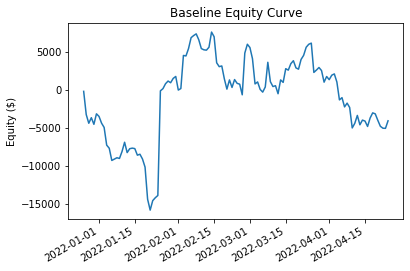

In [52]:
# Iterate through each model
for model_to_test in models_to_test:
    print(f"Model under test:{model_to_test}", end = '\n')
    equity_curve = pd.DataFrame()
    # iterate through each train/test split in the data
    for dataset_number in range(len(train_X_sets)):
        
        print(f"Train length: {len(train_X_sets[dataset_number])}, Data split: {dataset_number+1}/{len(train_X_sets)}    ", end = '\r')
        
        X_train = train_X_sets[dataset_number]
        X_test = test_X_sets[dataset_number]
        
        y_train = train_y_sets[dataset_number]
        y_test = test_y_sets[dataset_number]
        
        if model_to_test == 'baseline':
            # Test baseline
            baseline_selection, baseline_train_accuracy, baseline_test_accuracy = test_class_baseline(y_train,
                                                                                                      y_test,
                                                                                                      set_number = dataset_number+1, 
                                                                                                      print_results = False)

            train_baseline_equity_results, test_baseline_equity_results = get_class_baseline_equity_results(y_train, 
                                                                                                           y_test, 
                                                                                                           baseline_selection)
            # Consolidate the baseline results from each split
            all_baseline_results = consolidate_baseline_results(all_baseline_results,
                                                            dataset_number,
                                                            baseline_train_accuracy,
                                                            baseline_test_accuracy,
                                                           train_baseline_equity_results, 
                                                            test_baseline_equity_results)
            
            baseline_equity_curve = get_equity_curve(baseline_equity_curve, test_baseline_equity_results)
            
            continue
            
        # Train and test using model, output classification reports and predictions
        train_classification_report, test_classification_report, train_predictions, test_predictions = train_and_test_dataset(model_to_test,
                               X_train, 
                               X_test, 
                               y_train, 
                               y_test, 
                               target, print_results = False)
        
        train_equity_results, test_equity_results = get_equity_results(y_train, 
                                                                       y_test,  
                                                                       train_predictions, 
                                                                       test_predictions)
        

        # Consolidate the classification modeling results
        all_classification_dataset_model_results = consolidate_class_model_results(dataset_number,
                                                                           all_classification_dataset_model_results,
                                                                     train_classification_report,
                                                                     test_classification_report,
                                                                                  train_equity_results,
                                                                                  test_equity_results)
        # Generate equity curve of the test sets
        equity_curve= get_equity_curve(equity_curve, test_equity_results)
    
    if model_to_test == 'baseline':
        equity_plots_data[model_to_test] = baseline_equity_curve
    else:                                                 
        equity_plots_data[str(model_to_test)] = equity_curve
    
    # plot equity curve of all test splits for each model
    # equity_curve.plot()
    # plt.title(f'Equity Curve: {model_to_test}')
    # plt.ylabel('Equity ($)')

# plot baseline equity curve for test splits
baseline_equity_curve.plot(legend=False)
plt.title(f'Baseline Equity Curve')
plt.ylabel('Equity ($)')
    
        
average_cross_validate_result = consolidate_datasets(all_baseline_results, 
                                                     all_classification_dataset_model_results)

In [53]:
average_cross_validate_result.sort_values(by=['pct_return_to_std_test', 'train_to_test_dropoff_pct'], ascending=[False, True]).head(5)

,hyperparameters,algorithm,features_used,train_accuracy,test_accuracy,train_to_test_dropoff_pct,avg_train_return,avg_test_return,pct_return_to_std_train,pct_return_to_std_test,pct_avg_train_return,pct_avg_test_return
9,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",RandomForestClassifier,"['atr_above_threshold_0.01', 'atr_above_thresh...",0.642128,0.541667,0.156565,140.052514,156.928613,0.207419,0.112160,0.007909,0.003628
8,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",RandomForestClassifier,"['atr_above_threshold_0.01', 'atr_above_thresh...",0.608731,0.533333,0.123159,104.010959,131.083496,0.163520,0.081484,0.006284,0.002868
5,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",KNeighborsClassifier,"['atr_above_threshold_0.01', 'atr_above_thresh...",0.559828,0.508333,0.092097,51.905057,49.961816,0.095495,0.063746,0.003703,0.000865
12,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",DecisionTreeClassifier,"['atr_above_threshold_0.01', 'atr_above_thresh...",0.588263,0.500000,0.150788,83.918020,87.505111,0.131230,0.041697,0.005066,0.002273
4,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",KNeighborsClassifier,"['atr_above_threshold_0.01', 'atr_above_thresh...",0.706966,0.450000,0.363473,139.609804,-25.923145,0.297918,-0.008088,0.011121,-0.000570


In [54]:
average_cross_validate_result[average_cross_validate_result.index == 5].hyperparameters[5]

"{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 50, 'p': 2, 'weights': 'uniform'}"

Best model is K-Nearest Neighbors Classifier n_neighbors = 50. It experienced an average (per split) dropoff in train to validate accuracy of 9% and Average Percent Return to Standard Deviation of Returns Ratio of 0.064. This model will be tested on the withheld test set and will use as train set the 2620 datapoints before test starts.

In [55]:
features_to_use = ['close','atr_above_threshold_0.01',
       'atr_above_threshold_0.05', 'atr_above_threshold_0.1',
       'atr_above_threshold_0.2', 'atr_above_threshold_0.3',
       'avg-fees-per-transaction', 'cost-per-transaction-percent',
       'cost-per-transaction', 'difficulty', 'hash-rate', 'miners-revenue',
       'transaction-fees-to-miners', 'sentiment', 'obv_close_product']

features_to_scale = ['atr_above_threshold_0.01',
       'atr_above_threshold_0.05', 'atr_above_threshold_0.1',
       'atr_above_threshold_0.2', 'atr_above_threshold_0.3',
       'avg-fees-per-transaction', 'cost-per-transaction-percent',
       'cost-per-transaction', 'difficulty', 'hash-rate', 'miners-revenue',
       'transaction-fees-to-miners', 'sentiment', 'obv_close_product']


# Define models to test
model_to_test = KNeighborsClassifier(n_neighbors=50)

# Define the target
target = 'fwd_close_positive'
other_targets = ['close','fwd_log_ret', 'fwd_ret', 'fwd_pct_chg']

# Use withheld test set on final model
X_final_test = df[features_to_scale].iloc[-test_size:]
y_final_test = df[[target,'fwd_ret','close']].iloc[-test_size:]

# Use preceding X_train_length datapoints (2620) for training the final model
X_final_train = df[features_to_scale].iloc[-(2620+test_size):-test_size]
y_final_train = df[[target,'fwd_ret','close']].iloc[-(2620+test_size):-test_size]

# Perform scaling after the split so scaler can be fit to each train set individually
X_final_train_scaled, X_final_test_scaled = scale_X(X_final_train, X_final_test, features_to_use, features_to_scale, scaler_type = StandardScaler())

# Train and test using model, output classification reports and predictions
train_classification_report, test_classification_report, train_predictions, test_predictions = train_and_test_dataset(model_to_test,
                       X_final_train_scaled, 
                       X_final_test_scaled, 
                       y_final_train, 
                       y_final_test, 
                       target, print_results = False)

train_equity_results, final_test_equity_results = get_equity_results(y_final_train, 
                                                               y_final_test,  
                                                               train_predictions, 
                                                               test_predictions)


final_test_equity_curve = pd.DataFrame()
# Generate equity curve of the test sets
final_test_equity_curve= get_equity_curve(final_test_equity_curve, final_test_equity_results)


# all_classification_dataset_model_results = pd.DataFrame()
# all_baseline_results = pd.DataFrame()

# baseline_equity_curve = pd.DataFrame()
# equity_plots_data = {}

In [62]:
final_model_validate_test_equity = pd.concat([equity_plots_data['KNeighborsClassifier(n_neighbors=50)'], final_test_equity_curve])

In [78]:
equity_plots_data['KNeighborsClassifier(n_neighbors=50)']

,0
2021-12-26,-169.097656
2021-12-27,2882.464844
2021-12-28,4026.609375
2021-12-29,3293.195313
2021-12-30,4164.875000
...,...
2022-04-20,9543.699220
2022-04-21,8756.656252
2022-04-22,9010.246096
2022-04-23,9027.683596


In [77]:
final_test_equity_curve.iloc[-1]

0   -9739.810548
Name: 2022-05-24 00:00:00, dtype: float64

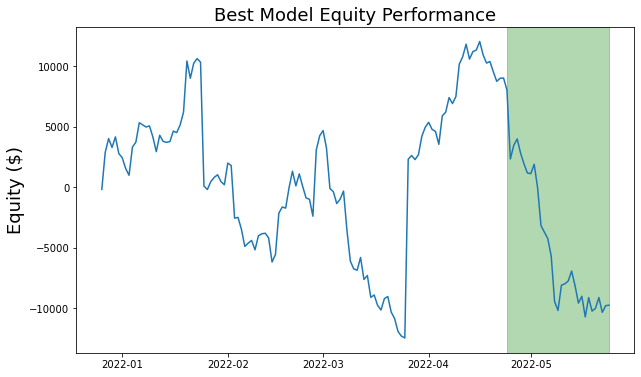

In [73]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(final_model_validate_test_equity)
ax.set_title('Best Model Equity Performance', fontsize = 18)
ax.set_ylabel('Equity ($)', fontsize = 18)

final_test_start = df.index.max()-timedelta(days = test_size)
final_test_end = df.index.max()

# ax.axvspan(train_start, train_end, label = "train", color = "green", alpha = 0.3)
ax.axvspan(final_test_start, final_test_end, label = "validate", color = "green", alpha = 0.3)

In [ ]:
# Iterate through each model
for model_to_test in models_to_test:
    print(f"Model under test:{model_to_test}", end = '\n')
    equity_curve = pd.DataFrame()
    # iterate through each train/test split in the data
    for dataset_number in range(len(train_X_sets)):
        
        print(f"Data split: {dataset_number+1}/{len(train_X_sets)}    ", end = '\r')
        
        X_train = train_X_sets[dataset_number]
        X_test = test_X_sets[dataset_number]
        
        y_train = train_y_sets[dataset_number]
        y_test = test_y_sets[dataset_number]
        
        if model_to_test == 'baseline':
            # Test baseline
            baseline_selection, baseline_train_accuracy, baseline_test_accuracy = test_class_baseline(y_train,
                                                                                                      y_test,
                                                                                                      set_number = dataset_number+1, 
                                                                                                      print_results = False)

            train_baseline_equity_results, test_baseline_equity_results = get_class_baseline_equity_results(y_train, 
                                                                                                           y_test, 
                                                                                                           baseline_selection)
            # Consolidate the baseline results from each split
            all_baseline_results = consolidate_baseline_results(all_baseline_results,
                                                            dataset_number,
                                                            baseline_train_accuracy,
                                                            baseline_test_accuracy,
                                                           train_baseline_equity_results, 
                                                            test_baseline_equity_results)
            
            baseline_equity_curve = get_equity_curve(baseline_equity_curve, test_baseline_equity_results)
            
            continue
            
        # Train and test using model, output classification reports and predictions
        train_classification_report, test_classification_report, train_predictions, test_predictions = train_and_test_dataset(model_to_test,
                               X_train, 
                               X_test, 
                               y_train, 
                               y_test, 
                               target, print_results = False)
        
        train_equity_results, test_equity_results = get_equity_results(y_train, 
                                                                       y_test,  
                                                                       train_predictions, 
                                                                       test_predictions)
        

        # Consolidate the classification modeling results
        all_classification_dataset_model_results = consolidate_class_model_results(dataset_number,
                                                                           all_classification_dataset_model_results,
                                                                     train_classification_report,
                                                                     test_classification_report,
                                                                                  train_equity_results,
                                                                                  test_equity_results)
        # Generate equity curve of the test sets
        equity_curve= get_equity_curve(equity_curve, test_equity_results)
    
    if model_to_test == 'baseline':
        equity_plots_data[model_to_test] = baseline_equity_curve
    else:                                                 
        equity_plots_data[model_to_test] = equity_curve
    
    # plot equity curve of all test splits for each model
    # equity_curve.plot()
    # plt.title(f'Equity Curve: {model_to_test}')
    # plt.ylabel('Equity ($)')

# plot baseline equity curve for test splits
baseline_equity_curve.plot(legend=False)
plt.title(f'Baseline Equity Curve')
plt.ylabel('Equity ($)')
    
        
average_cross_validate_result = consolidate_datasets(all_baseline_results, 
                                                     all_classification_dataset_model_results)

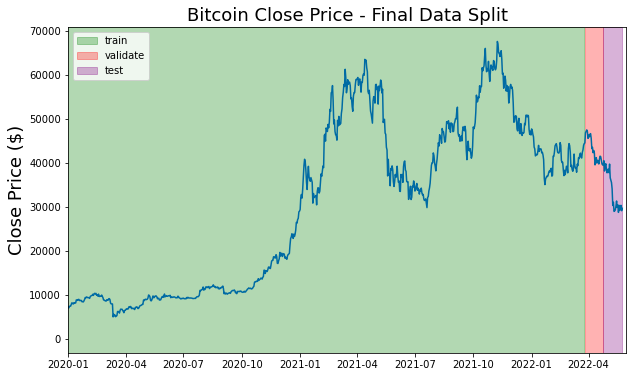

In [98]:
for dataset_number in range(len(train_X_sets)):
    
    if dataset_number+1 == len(train_X_sets):
        fig, ax = plt.subplots(figsize = (10,6))
        ax.plot(df.close)
        ax.set_xlim(left = pd.Timestamp('2020-01-01'), right = pd.Timestamp('2022-05-30'))
        train_start = train_X_sets[dataset_number].index.min()
        train_end = train_X_sets[dataset_number].index.max()
        test_start = test_X_sets[dataset_number].index.min()
        test_end = test_X_sets[dataset_number].index.max()

        final_test_start = df.index.max()-timedelta(days = test_size)
        final_test_end = df.index.max()

        ax.axvspan(train_start, train_end, label = "train", color = "green", alpha = 0.3)
        ax.axvspan(test_start, test_end, label = "validate", color = "red", alpha = 0.3)
        ax.axvspan(final_test_start, final_test_end, label = "test", color = "purple", alpha = 0.3)
        ax.legend()
        plt.title('Bitcoin Close Price - Final Data Split', fontsize = 18)
        plt.ylabel('Close Price ($)', fontsize = 18)
        plt.show()

    

In [46]:
for dataset_number in range(len(train_X_sets))[2:]:
#     df.close.plot(color='g', label = 'whole dataset')
#     train_X_sets[dataset_number].close.plot(color = 'r', label = 'train')
#     test_X_sets[dataset_number].close.plot(color = 'b', label = 'test')
#     plt.xlim(df.index.min(), df.index.max())
#     plt.title(f'Split number {dataset_number+1}')
    
    # train_X_sets, test_X_sets, train_y_sets, test_y_sets

IndentationError: expected an indented block (3727115681.py, line 8)

### Modeling extras

In [ ]:
# baseline - what is the most common class?
y_train.fwd_close_positive.value_counts()

Most common class is a positive forward close, therefore this will be used as baseline. Essentially this means everyday we predict a positive close. How often would we be correct?

In [ ]:
# Get the mode from train
baseline_selection = y_train.fwd_close_positive.mode()[0]

# Create column with baseline predictions
y_train['baseline_performance'] = y_train.fwd_close_positive == baseline_selection

# Take the mean to get accuracy
y_train.baseline_performance.mean()

54.5% is our baseline accuracy from train

In [ ]:
class_model = DecisionTreeClassifier(max_depth = 5, min_samples_leaf=2)

class_model.fit(X_train, y_train)

y_train['dtc']=class_model.predict(X_train)

accuracy_score(y_train.fwd_close_positive, y_train.dtc)

classification_report(y_train.fwd_close_positive, y_train.dtc, output_dict=True)

How would baseline (predict positive close every day)

In [ ]:
y_test['dtc'] = class_model.predict(X_test)
accuracy_score(y_test.fwd_close_positive, y_test.dtc)

# NLP Exploration

In [ ]:
sia = nltk.sentiment.SentimentIntensityAnalyzer()

In [ ]:
def get_later_tweets(tweet_csv = 'csv/latest_tweets.csv'):
    
    start_read_time = datetime.now()
    
    print("starting reading csv at: ", start_read_time)
    
    # https://www.kaggle.com/datasets/kaushiksuresh147/bitcoin-tweets
    latest_tweets = pd.read_csv(tweet_csv)
    
    print("done reading csv, took ", ((datetime.now() - start_read_time).seconds)/60, " minutes")
    
    # some values don't have proper date values
    latest_tweets= latest_tweets[latest_tweets.date.str.len()==19]

    # Set index to date
    latest_tweets.index = pd.to_datetime(latest_tweets.date)

    # create date column
    latest_tweets['date_of_tweet'] = latest_tweets.index.date

    # sort index and just use date and text going forward
    latest_tweets = latest_tweets.sort_index()[['date','text']]
    
    prices_df = tidy.explore_df()
    # Join with prices df to get Bitcoin price change for that date
    latest_tweets = latest_tweets.merge(prices_df, how='left',left_on=latest_tweets.index.date, right_on = prices_df.index.date)

    latest_tweets.index = pd.to_datetime(latest_tweets.key_0)

    latest_tweets = latest_tweets[['fwd_log_ret','text']]

    latest_tweets.index.name = ""
    
    return latest_tweets

In [ ]:
latest_tweets = get_later_tweets()

In [ ]:
latest_tweets.head()

In [ ]:
latest_tweets['sentiment'] = latest_tweets.text.apply(lambda msg: sia.polarity_scores(msg)['compound'])

In [ ]:
latest_tweets.resample('D').fwd_log_ret.agg('mean').plot()

In [ ]:
def read_and_clean_early_tweets(nrows = 1_000_000, time_column = 'timestamp', csv_location = 'csv/early_tweets.csv'):
    """ Reads in early tweets (until 2019), clean up the dates, and outputs dataframe with date and text of tweet """
    
    # Define required columns from the csv - this should speed up load
    req_cols = ['timestamp','likes','retweets','text']
    
    # Read CSV
    tweets = pd.read_csv(csv_location,nrows = nrows ,on_bad_lines='skip',sep=';', usecols = req_cols)
    
    print("Completed reading in csv, shape: ", tweets.shape)
    
    # Clean dates (sometimes the time column has non time values. If it's a timestamp should have set number of characters
    if time_column == 'time': # For reading in later tweets, that csv's time column is called 'time'
        tweets = tweets[tweets[time_column].str.len()==25]
    
    # convert time to datetime
    tweets[time_column]= pd.to_datetime(tweets[time_column])
    
    # Create date column
    tweets['date'] = tweets[time_column].dt.date
    
    # Only use date and text columns
    tweets = tweets[['date','text']]
    
    tweets.index = pd.to_datetime(tweets.date)
    
    return tweets

In [ ]:
# req_cols = ['timestamp','likes','retweets','text']
# tweets = pd.read_csv('csv/early_tweets.csv',nrows = 1000000,on_bad_lines='skip',sep=';', usecols = req_cols)
early_tweets = read_and_clean_early_tweets()

In [ ]:
early_tweets.shape

In [ ]:
early_tweets.head()

In [ ]:
early_tweets['sentiment'] = early_tweets.text.apply(lambda msg: sia.polarity_scores(msg)['compound'])

In [ ]:
tweets.resample('D').sentiment.mean().plot()

In [ ]:
def initial_tweet_clean(tweets,time_column = 'time'):
    # Clean dates
    if time_column == 'time':
        tweets = tweets[tweets[time_column].str.len()==25]

    tweets[time_column]= pd.to_datetime(tweets[time_column])

    tweets['date'] = tweets[time_column].dt.date

    tweets = tweets[['date','text']]
    
    return tweets


In [ ]:
cleaned_early_tweets = read_and_clean_early_tweets()

In [ ]:
# cleaned_tweets = initial_tweet_clean(tweets, 'timestamp')

In [ ]:
cleaned_tweets['sentiment'] = cleaned_tweets.text.apply(lambda msg: sia.polarity_scores(msg)['compound'])

In [ ]:
prepared_tweets = tidy.prepare_df(tweets.sample(5000), 'text')

prices = df

prepared_tweets = prepared_tweets.merge(prices, how = 'left', left_on = 'date', right_on = prices.index.date)

prepared_tweets.index = pd.to_datetime(prepared_tweets.date)

In [ ]:
lem_and_ret = prepared_tweets.resample('D').agg({'lemmatized':' '.join, 'fwd_log_ret':np.mean, 'fwd_close_positive':np.mean})

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

In [ ]:
tweets['sentiment'] = tweets.text.apply(lambda msg: sia.polarity_scores(msg)['compound'])

In [ ]:
tweets.date.max()

## Short modeling test

In [ ]:
train = lem_and_ret.iloc[:20]

validate = lem_and_ret.iloc[20:]

In [ ]:
target = 'fwd_close_positive'

In [ ]:
# Instantiate the feature extraction method
feature_extraction_method = CountVectorizer(ngram_range=(1,1))

# Perform feature extraction on lemmatized text from train
X_train = feature_extraction_method.fit_transform(train.lemmatized)

# Generate dataframe of results of feature extraction
train_vectorizer_df = pd.DataFrame(X_train.todense(), columns=feature_extraction_method.get_feature_names_out())

# Set index to train index
train_vectorizer_df.index = train.index

# Add in other features (lengths of readme)
# X_train = pd.concat([train_vectorizer_df,train[['original_length','stem_length', 'lem_length', 'original_word_count',
#        'stemmed_word_count', 'lemmatized_word_count']]], axis = 1)

# Scale features in train (necessary for logistic regression)
# X_train_scaled = scaler.fit_transform(X_train)

# Perform feature extraction and add in additional features on validate
X_validate = feature_extraction_method.transform(validate.lemmatized)
validate_vectorizer_df = pd.DataFrame(X_validate.todense(), columns=feature_extraction_method.get_feature_names_out())
validate_vectorizer_df.index = validate.index

# X_validate = pd.concat([validate_vectorizer_df,validate[['original_length','stem_length', 'lem_length', 'original_word_count',
#        'stemmed_word_count', 'lemmatized_word_count']]], axis = 1)

# Scale validate
# X_validate_scaled = scaler.transform(X_validate)

# Define target 
y_train = train[target]
y_validate = validate[target]

In [ ]:
# Create dataframe of results from train and validate
train_results=pd.DataFrame(dict(actual = y_train))
validate_results = pd.DataFrame(dict(actual = y_validate))

class_model = LogisticRegression()
# Fit model to scaled train data 
model_to_use = class_model.fit(X_train, y_train)

# Predict on train and validate
train_results['predicted'] = model_to_use.predict(X_train)
validate_results['predicted'] = model_to_use.predict(X_validate)


In [ ]:
# Generate classification reports for train and validate
train_class_report = classification_report(train_results.actual, train_results.predicted, output_dict = True)
validate_class_report = classification_report(validate_results.actual, validate_results.predicted,output_dict=True)

In [ ]:

print('Accuracy: {:.2%}'.format(accuracy_score(train_results.actual, train_results.predicted)))
print('---')
# print('Train Confusion Matrix')
# print(pd.crosstab(train_results_tfidf.predicted, train_results_tfidf.actual))
print('---')
print(pd.DataFrame(train_class_report))


print('Accuracy: {:.2%}'.format(accuracy_score(validate_results.actual, validate_results.predicted)))
print('---')
# print('Validate Confusion Matrix')
# print(pd.crosstab(validate_results_tfidf.predicted, validate_results_tfidf.actual))
print('---')
print(pd.DataFrame(validate_class_report))